#Context

{% comment %}

# Notes for those who downloaded the notebook

The notebook should just work as long as you put the sample file (`savedrecs.txt`) in the same directory as this file.

The one issue you will have is that the urls will not work. To make them work you will need to replace ``{{ site.baseurl }}`` with `http://networkslab.org/metaknowledge`, sorry about that.

{% endcomment %}

_metaknowledge_ is a python library for creating and analyzing scientific metadata. It uses records obtained from Web of Science (WOS) and mostly produces graphs. As it is intended to be usable by those who do not know much python. This page will be a short overview of its capabilities, to allow you to use it for your own work. For complete coverage of the package as well as install instructions read the full the documentation [here]({{ site.baseurl }}/documentation).

This document was made from a [jupyter](https://jupyter.org) notebook, if you know how to use them, you can download the notebook [here]({{ site.baseurl }}/examples/metaknowledgeExamples.ipynb) and the sample file is [here]({{ site.baseurl }}/examples/savedrecs.txt) if you wish to have an interactive version of this page. Now lets begin.

#Importing

First you need to import the _metaknowledge_ package


In [1]:
import metaknowledge as mk

And you will often need the [_networkx_](https://networkx.github.io/documentation/networkx-1.9.1/) package


In [2]:
import networkx as nx

I am using [_matplotlib_](http://matplotlib.org/) to display the graphs and to make them look nice when displayed


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

_metaknowledge_ also has a _matplotlib_ based graph [visualizer]({{ site.baseurl }}/docs/visual#visual)


In [4]:
import metaknowledge.visual as mkv

[_pandas_](http://pandas.pydata.org/) is also used in one example


In [5]:
import pandas

# Reading Files

The files from the Web of Science (WOS) can be loaded into a [`RecordCollections`]({{ site.baseurl }}/docs/RecordCollection#RecordCollection) by creating a `RecordCollection` with the path to the files given to it as a string.


In [6]:
RC = mk.RecordCollection("savedrecs.txt")
repr(RC)

'savedrecs'

You can also read a whole directory, in this case it is reading the current working directory


In [7]:
RC = mk.RecordCollection(".")
repr(RC)

'files-from-.'

_metaknowledge_ can detect if a file is a valid WOS file or not and will read the entire directory and load only those that have the right header. You can also tell it to only read a certain type of file, by using the extension argument.


In [8]:
RC = mk.RecordCollection(".", extension = "txt")
repr(RC)

'txt-files-from-.'

Now you have a `RecordCollection` composed of all the WOS records in the selected file(s).


In [9]:
print("RC is a " + str(RC))

RC is a Collection of 32 records


You might have noticed I used two different ways to display the `RecordCollection`. `repr(RC)` will give you where _metaknowledge_ thinks the collection came from. While `str(RC)` will give you a nice string containing the number of `Records`.

# `Record` object

[`Record`]({{ site.baseurl }}/docs/Record#Record) is an object that contains a simple WOS record, for example a journal article, book, or conference proceedings. They are what [`RecordCollections`]({{ site.baseurl }}/docs/RecordCollection#RecordCollection) contain. To see an individual [`Record`]({{ site.baseurl }}/docs/Record#Record) at random from a `RecordCollection` you can use `peak()`


In [10]:
R = RC.peak()

A single `Record` can give you all the information it contains about its record. If for example you want its authors.


In [11]:
print(R.authorsFull)
print(R.AF)

['ROOSEN, G', 'IMBERT, C']
['ROOSEN, G', 'IMBERT, C']


Converting a `Record` to a string will give its title


In [12]:
print(R)

CALCULATION AND MEASUREMENT OF FORCES AND TORQUES APPLIED TO UNIAXIAL CRYSTAL BY EXTRAORDINARY WAVE


If you try to access a tag the `Record` does not have it will return `None`


In [13]:
print(R.GP)

None


There are two ways of getting each tag, one is using the WOS 2 letter abbreviation and the second is to use the human readable name. There is no standard for the human readable names, so they are specific to _metaknowledge_. To see how the WOS names map to the long names look at [tagFuncs]({{ site.baseurl }}/docs/tagFuncs#tagFuncs). If you want all the tags a `Record` has use [`activeTags()`](({{ site.baseurl }}/docs/Record#activeTags).


In [14]:
print(R.activeTags())

['PT', 'AU', 'AF', 'TI', 'SO', 'LA', 'DT', 'C1', 'CR', 'NR', 'TC', 'Z9', 'PU', 'PI', 'PA', 'SN', 'J9', 'JI', 'PY', 'VL', 'IS', 'BP', 'EP', 'PG', 'WC', 'SC', 'GA', 'UT']


#`RecordCollection` object

[`RecordCollection`]({{ site.baseurl }}/docs/RecordCollection#RecordCollection) is the object that _metaknowledge_ uses the most. It is your interface with the data you want.

To iterate over all of the `Records` you can use a for loop


In [15]:
for R in RC:
    print(R)

CALCULATION AND MEASUREMENT OF FORCES AND TORQUES APPLIED TO UNIAXIAL CRYSTAL BY EXTRAORDINARY WAVE
WHY ENERGY FLUX AND ABRAHAMS PHOTON MOMENTUM ARE MACROSCOPICALLY SUBSTITUTED FOR MOMENTUM DENSITY AND MINKOWSKIS PHOTON MOMENTUM
INTERNAL PHOTON IMPULSE OF DIELECTRIC AND ON COUPLE APPLIED TO ANISOTROPIC CRYSTAL
Longitudinal and transverse effects of nonspecular reflection
SPIN ANGULAR-MOMENTUM OF A FIELD INTERACTING WITH A PLANE INTERFACE
Goos-Hanchen shift as a probe in evanescent slab waveguide sensors
Numerical study of the displacement of a three-dimensional Gaussian beam transmitted at total internal reflection. Near-field applications
EXPERIMENTS IN PHENOMENOLOGICAL ELECTRODYNAMICS AND THE ELECTROMAGNETIC ENERGY-MOMENTUM TENSOR
SHIFTS OF COHERENT-LIGHT BEAMS ON REFLECTION AT PLANE INTERFACES BETWEEN ISOTROPIC MEDIA
INTERFERENCE THEORY OF REFLECTION FROM MULTILAYERED MEDIA
Experimental observation of the Imbert-Fedorov transverse displacement after a single total reflection
DISCUSS

The individual `Records` are index by their WOS numbers so you can access a specific one in the collection if you know its number.


In [16]:
RC.getWOS("WOS:A1979GV55600001")

#`Citation` object

[`Citation`]({{ site.baseurl }}/docs/Citation#Citation) is an object to contain the results of parsing a citation. They can be created from a `Record`


In [17]:
Cite = R.createCitation()
print(Cite)

Pillon F, 2005, APPL PHYS B-LASERS O, V80, P355, DOI 10.1007/s00340-005-1728-2


`Citations` allow for the raw strings of citations to be manipulated easily by _metaknowledge_.

#Filtering

The for loop shown above is the main way to filter a RecordCollection, that said there are a few builtin filters, e.g. [`yearSplit()`]({{ site.baseurl }}/docs/RecordCollection#yearSplit), but the for loop is an easily generalized way of filtering that is relatively simple to read so it the main way you should filter. An example of the workflow is as follows:

First create a new RecordCollection


In [18]:
RCfiltered = mk.RecordCollection()

Then add the records that meet your condition, in this case that their title's start with `'A'`


In [19]:
for R in RC:
    if R.title[0] == 'A':
        RCfiltered.addRec(R)

In [20]:
print(RCfiltered)

Collection of 3 records


Now you have a RecordCollection `RCfiltered` of all the `Records` whose titles begin with `'A'`.

One note about implementing this, the above code does not handle the case in which the title is missing i.e. `R.title` is `None`. You will have to deal with this on your own.

Two builtin functions to filter collections are [`yearSplit()`]({{ site.baseurl }}/docs/RecordCollection#yearSplit) and [`localCitesOf()`]({{ site.baseurl }}/docs/RecordCollection#localCitesOf). To get a RecordCollection of all Records between 1970 and 1979:


In [21]:
RC70 = RC.yearSplit(1970, 1979)
print(RC70)

Collection of 19 records


The second function [`localCitesOf()`]({{ site.baseurl }}/docs/RecordCollection#localCitesOf) takes in an object that a [Citation]({{ site.baseurl }}/docs/Citation#Citation) can be created from and returns a RecordCollection of all the Records that cite it. So to see all the records that cite `"Yariv A., 1971, INTRO OPTICAL ELECTR"`.


In [22]:
RCintroOpt = RC.localCitesOf("Yariv A., 1971, INTRO OPTICAL ELECTR")
print(RCintroOpt)

Collection of 1 records


# Exporting RecordCollections

Now you have a filtered RecordCollection you can write it as a file with [`writeFile()`]({{ site.baseurl }}/docs/RecordCollection#writeFile)


In [23]:
 RCfiltered.writeFile("Records_Starting_with_A.txt")

The written file is identical to one of those produced by WOS.

If you wish to have a more useful file use [`writeCSV()`]({{ site.baseurl }}/docs/RecordCollection#writeCSV) which creates a CSV file of all the tags as columns and the Records as rows. IF you only care about a few tags the `onlyTheseTags` argument allows you to control the tags.


In [24]:
selectedTags = ['TI', 'UT', 'CR', 'AF']

This will give only the title, WOS number, citations, and authors.


In [25]:
RCfiltered.writeCSV("Records_Starting_with_A.csv", onlyTheseTags = selectedTags)

The last export feature is for using _metaknowledge_ with other packages, in particular [_pandas_](http://pandas.pydata.org/) but others should also work. [`makeDict()`]({{ site.baseurl }}/docs/RecordCollection#makeDict) creates a dictionary with tags as keys and lists as values with each index of the lists corresponding to a Record. _pandas_ can accept these directly to make DataFrames.


In [26]:
recDataFrame = pandas.DataFrame(RC.makeDict())

# Making a co-citation network

To make a basic co-citation network of Records use [`coCiteNetwork()`]({{ site.baseurl }}/docs/RecordCollection#coCiteNetwork).


In [27]:
coCites = RC.coCiteNetwork()
print(mk.graphStats(coCites, makeString = True)) #makestring by default is True so it is not strictly necessary to include

The graph has 601 nodes, 19492 edges, 0 isolates, 4 self loops, a density of 0.108109 and a transitivity of 0.691662


[`graphStats()`]({{ site.baseurl }}/docs/metaknowledge#graphStats) is a function to extract some of the statists of a graph and make them into a nice string.

`coCites` is now a [_networkx_](https://networkx.github.io/documentation/networkx-1.9.1/) graph of the co-citation network, with the hashes of the `Citations` as nodes and the full citations stored  as an attributes. Lets look at one node


In [28]:
coCites.nodes(data = True)[0]

(-7195789643546077181,
 {'count': 1, 'info': 'Saleh B. E. A., 1991, FUNDAMENTALS PHOTONI'})

and an edge


In [29]:
coCites.edges(data = True)[0]

(-7195789643546077181, 188038831039612651, {'weight': 1})

All the graphs _metaknowledge_ use are _networkx_ graphs, a few functions to trim them are implemented in _metaknowledge_, [here](#filtering-graphs) is the example section, but many useful functions are implemented by it. Read the documentation [here](https://networkx.github.io/documentation/networkx-1.9.1/) for more information.

The `coCiteNetwork()` function has many options for filtering and determining the nodes. The default is to use the `Citations` themselves. If you wanted to make a network of co-citations of journals you would have to make the node type `'journal'` and remove the non-journals.


In [30]:
coCiteJournals = RC.coCiteNetwork(nodeType = 'journal', dropNonJournals = True)
print(mk.graphStats(coCiteJournals))

The graph has 89 nodes, 1383 edges, 0 isolates, 40 self loops, a density of 0.353166 and a transitivity of 0.640306


Lets take a look at the graph after a quick spring layout


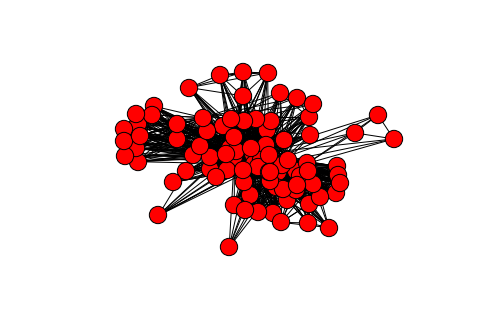

In [31]:
nx.draw_spring(coCiteJournals)

A bit basic but gives a general idea. If you want to make a much better looking and more informative visualization you could try [gephi](https://gephi.github.io/) or [visone](http://visone.info/). Exporting to them is covered below in [**Exporting graphs**](#exporting-graphs).

# Making a citation network

The [`citationNetwork()`]({{ site.baseurl }}/docs/RecordCollection#citationNetwork) method is nearly identical to `coCiteNetwork()` in its parameters. It has one additional keyword argument `directed` that controls if it produces a directed network. Read [**Making a co-citation network**]({{ site.baseurl }}/examples/#Making-a-co-citation-network) to learn more about `citationNetwork()`.

One small example is still worth providing. If you want to make a network of the citations of years by other years and have the letter `'A'` in them then you would write:


In [32]:
citationsA = RC.citationNetwork(nodeType = 'year', keyWords = ['A'])
print(mk.graphStats(citationsA))

The graph has 18 nodes, 24 edges, 0 isolates, 1 self loops, a density of 0.0784314 and a transitivity of 0.0344828


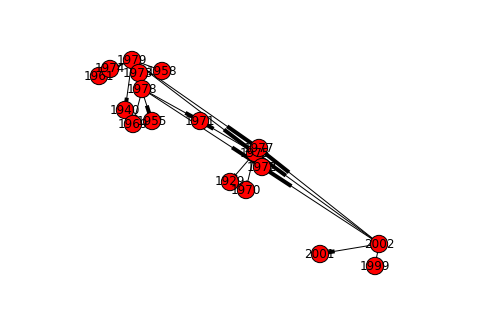

In [33]:
nx.draw_spring(citationsA, with_labels = True)

# Making a co-author network

The [`coAuthNetwork()`]({{ site.baseurl }}/docs/RecordCollection#coAuthNetwork) function produces the co-authorship network of the RecordCollection as is used as shown


In [34]:
coAuths = RC.coAuthNetwork()
print(mk.graphStats(coAuths))

The graph has 45 nodes, 46 edges, 9 isolates, 0 self loops, a density of 0.0464646 and a transitivity of 0.822581


# Making a one-mode network

In addition to the specialized network generators _metaknowledge_ lets you make a one-mode co-occurence network of any of the WOS tags, with the [oneModeNetwork()]({{ site.baseurl }}/docs/RecordCollection#oneModeNetwork) function. For examples the WOS subject tag `'WC'` can be examined.


In [35]:
wcCoOccurs = RC.oneModeNetwork('WC')
print(mk.graphStats(wcCoOccurs))

The graph has 9 nodes, 3 edges, 3 isolates, 0 self loops, a density of 0.0833333 and a transitivity of 0


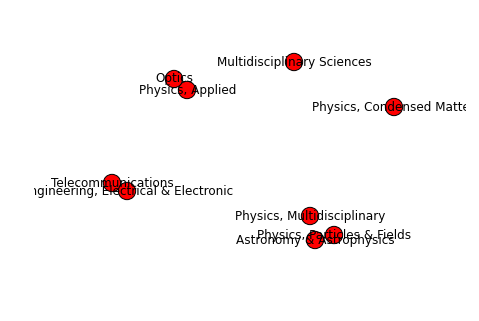

In [36]:
nx.draw_spring(wcCoOccurs, with_labels = True)

# Making a two-mode network

If you wish to study the relationships between 2 tags you can use the [`twoModeNetwork()`]({{ site.baseurl }}/docs/RecordCollection#twoModeNetwork) function which creates a two mode network showing the connections between the tags. For example to look at the connections between titles(`'TI'`) and subjects (`'WC'`)


In [37]:
ti_wc = RC.twoModeNetwork('WC', 'title')
print(mk.graphStats(ti_wc))

The graph has 40 nodes, 35 edges, 0 isolates, 0 self loops, a density of 0.0448718 and a transitivity of 0


The network is directed by default with the first tag going to the second.


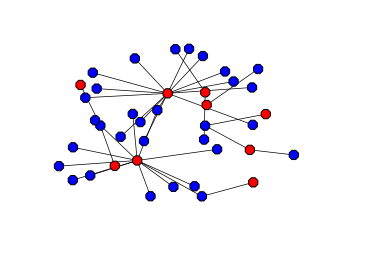

In [38]:
mkv.quickVisual(ti_wc, showLabel = False) #default is False as there are usually lots of labels

[`quickVisual()`]({{ site.baseurl }}/docs/visual#quickVisual) makes a graph with the different types of nodes coloured differently and a couple other small visual tweaks from _networkx_'s `draw_spring`.

# Making a multi-mode network

For any number of tags the [`nModeNetwork()`]({{ site.baseurl }}/docs/RecordCollection#nModeNetwork) function will do the same thing as the `oneModeNetwork()` but with any number of tags and it will keep track of their types. So to look at the co-occurence of titles `'TI'`, WOS number `'UT'` and authors `'AU'`.


In [39]:
tags = ['TI', 'UT', 'AU']
multiModeNet = RC.nModeNetwork(tags)
mk.graphStats(multiModeNet)

'The graph has 108 nodes, 163 edges, 0 isolates, 0 self loops, a density of 0.0282105 and a transitivity of 0.443946'

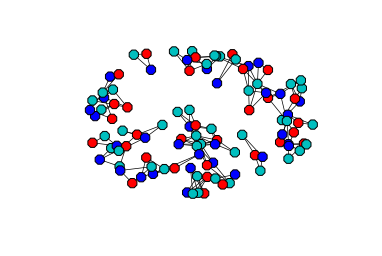

In [40]:
mkv.quickVisual(multiModeNet)

Beware this can very easily produce hairballs


In [41]:
tags = mk.tagsAndNames #All the tags, twice
sillyMultiModeNet = RC.nModeNetwork(tags)
mk.graphStats(sillyMultiModeNet)

'The graph has 1184 nodes, 59573 edges, 0 isolates, 1184 self loops, a density of 0.0850635 and a transitivity of 0.492152'

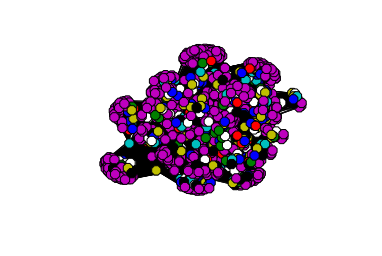

In [42]:
mkv.quickVisual(sillyMultiModeNet)

# Post processing graphs

If you wish to apply a well known algorithm or process to a graph [_networkx_](https://networkx.github.io/documentation/networkx-1.9.1/) is a good place to look as they do a good job at implementing  them.

One of the features it lacks though is pruning of graphs, _metaknowledge_ has these capabilities. To remove edges outside of some weight range, use [`drop_edges()`]({{ site.baseurl }}/docs/metaknowledge#drop_edges). For example if you wish to remove the self loops, edges with weight less than 2 and weight higher than 10 from `coCiteJournals`.


In [43]:
minWeight = 3
maxWeight = 10
proccessedCoCiteJournals = mk.drop_edges(coCiteJournals, minWeight, maxWeight, dropSelfLoops = True)
mk.graphStats(proccessedCoCiteJournals)

'The graph has 89 nodes, 466 edges, 1 isolates, 0 self loops, a density of 0.118999 and a transitivity of 0.213403'

Then to remove all the isolates, i.e. nodes with degree less than 1, use [`drop_nodesByDegree()`]({{ site.baseurl }}/docs/metaknowledge#drop_nodesByDegree)


In [44]:
proccessedCoCiteJournals = mk.drop_nodesByDegree(proccessedCoCiteJournals, 1)
mk.graphStats(proccessedCoCiteJournals)

'The graph has 88 nodes, 466 edges, 0 isolates, 0 self loops, a density of 0.121735 and a transitivity of 0.213403'

Now before the processing the graph can be seen [here](#Making-a-co-citation-network). After the processing it looks like


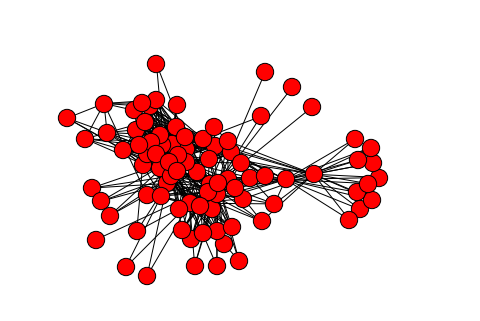

In [45]:
nx.draw_spring(proccessedCoCiteJournals)

Hm, it looks a bit thinner. Using a visualizer will make the difference a bit more noticeable.

#Exporting graphs

Now you have a graph the last step is to write it to disk. _networkx_ has a few ways of doing this, but they tend to be slow. _metaknowledge_ can write an edge list and node attribute file that contain all the information of the graph. The function to do this is called [`write_graph()`]({{ site.baseurl }}/docs/metaknowledge#write_graph). You give it the start of the file name and it makes two labeled files containing the graph.

In [46]:
mk.write_graph(proccessedCoCiteJournals, "FinalJournalCoCites")

These files are simple CSVs an can be read easily by most systems. If you want to read them back into Python the [`read_graph()`]({{ site.baseurl }}/docs/metaknowledge#read_graph) function will do that.


In [47]:
 FinalJournalCoCites = mk.read_graph("FinalJournalCoCites_edgeList.csv", "FinalJournalCoCites_nodeAttributes.csv")
mk.graphStats(FinalJournalCoCites)

'The graph has 88 nodes, 466 edges, 0 isolates, 0 self loops, a density of 0.121735 and a transitivity of 0.213403'

This is full example workflow for _metaknowledge_, the package is flexible and you hopefully will be able to customize it to do what you want (I assume you do not want the Records staring with 'A').